# **Project1: Finding Lane Lines on the Road** 

## Writeup

---

**Finding Lane Lines on the Road**

The goals / steps of this project are the following:
* Make a pipeline that finds lane lines on the road
* Reflect on your work in a written report



### Reflection

### 1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.

My pipeline consisted of 8 steps. 

1) Convert input image to grayscale, which is required for the edge detection
2) Run Canny edge detector
3) Determin the region of interest as a triangle for searching only on the road
4) Use Hough transformation to convert the edges within the ROI into lines
5) Allocate each line to the left or right lane and convert the lines into several points
6) Fit a line separately through the left and right lane points
7) Generate the starting and end point of the left and right lane
8) Mark the lanes in the original image


![alt text](/test_images_output/solidWhiteRight.jpg)


### 2. Identify potential shortcomings with your current pipeline


One shortcoming of the method is the decision if a line belongs to the left or right lane. Currently, this is only based on the angle, which is not always correct. Further, the lane is only described as a line, not as a curve.


### 3. Suggest possible improvements to your pipeline

A possible improvement would be to fit a curve through the lane points. In addition, the threshold for the canny detector could be lowered to get a better detection accuracy.


In [1]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os


In [2]:
# 1) Camera Chessboard Calibration and Distortion Correction
def calibrate_camera(path="camera_cal", nx=9, ny=6, visualization=False):
    # prepare object points
    # nx = number of inside corners in x
    # ny = number of inside corners in y

    # create an array of target points for the chess board
    objpoints_array = []
    objpoints = np.zeros((nx * ny, 3), np.float32)
    objpoints[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    imgpoints_array = []
    
    # Make a list of calibration images
    for jpg in os.listdir(path):

        img = cv2.imread(os.path.join("camera_cal", jpg))

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == False:
            continue

        objpoints_array.append(objpoints)
        imgpoints_array.append(corners)

    # calibrate the camera using the detected chessboard corners
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints_array, imgpoints_array, gray.shape[::-1], None, None)

    if ret == False:
        print("calibration error")
        
    # test the calibration on the "calibration1" image
    img = cv2.imread("camera_cal/calibration1.jpg")
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    if visualization:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title("Original Image", fontsize=50)
        ax2.imshow(undistorted)
        ax2.set_title("Undistorted", fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

    return mtx, dist

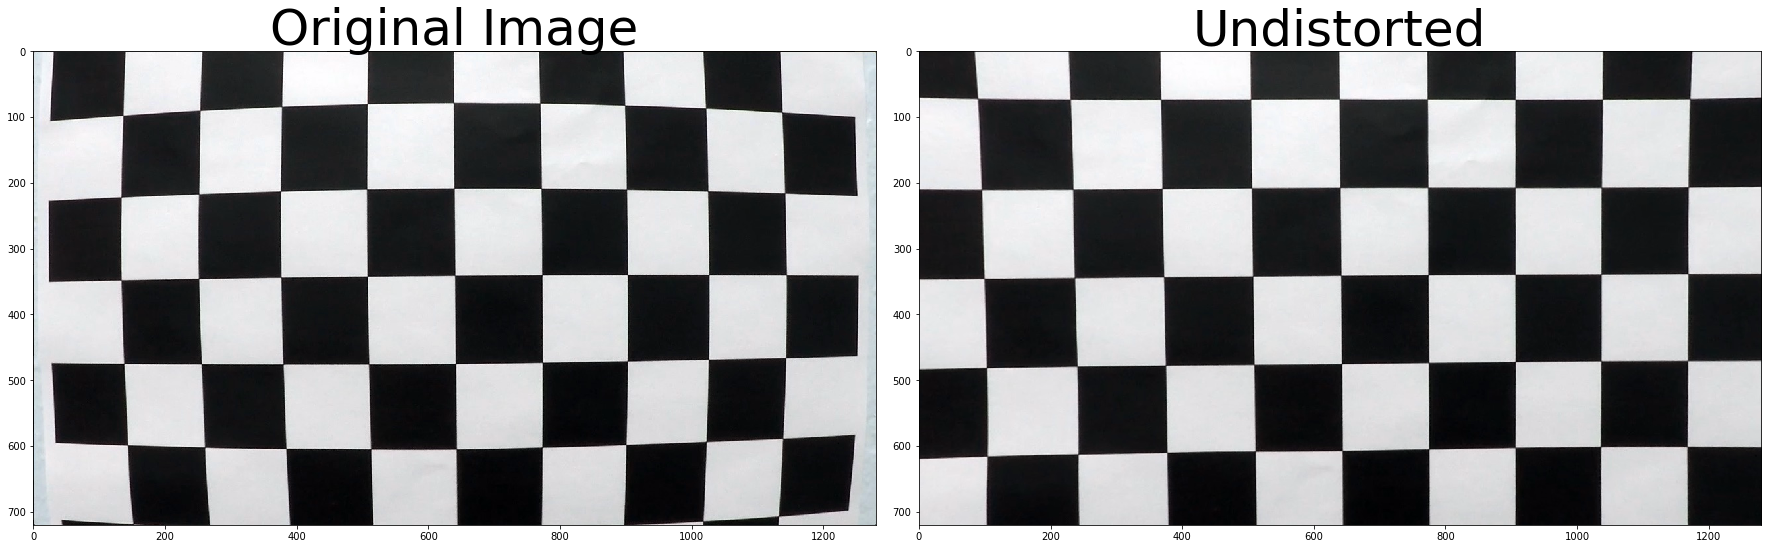

In [3]:
mtx, dist = calibrate_camera(visualization=True)

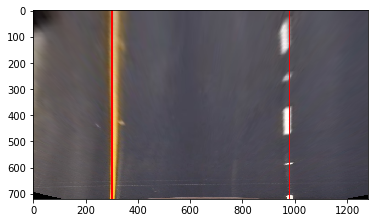

In [4]:
# Evaluate Perspective Transform Parameters on Straight line image (will be used later)

# Read image with straight lanes
img = mpimg.imread("test_images/straight_lines1.jpg")

# calibrate image
undistorted = cv2.undistort(img, mtx, dist, None, mtx)

# source parameters are the lane points in the undistorted image
src = np.float32([[587, 455], [701, 458], [250, 687], [1051, 687]])

# destination parameters are the target coordinates for the transformed image
dst = np.float32([[300, 0], [980, 0], [300, 719], [980, 719]])

# calculate the transformation matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
trans_img = cv2.warpPerspective(undistorted, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

# visualize the transformation
cv2.line(trans_img,(300, 0),(300, 719),(255,0,0),5)
cv2.line(trans_img,(980, 0),(980, 719),(255,0,0),4)
plt.imshow(trans_img)
plt.show()

In [5]:
# helper functions

def read_img(path, visualization):
    # reads an image as RGB
    img = mpimg.imread(path)
    if visualization:
        plt.imshow(img)
        plt.title('Original Image', fontsize=20)
        plt.show()
    return img

def detect_lines_via_saturation(img, thresh=(180,255)):
    # creates a binary image for parts of the image with high saturation
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    binary_saturation = np.zeros_like(S)
    binary_saturation[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_saturation

def detect_lines_via_sobel(img, thresh=(180,255)):
    # creates a binary image and detects areas with a high gradient in x direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelx = np.absolute(sobelx)
    sobelx = sobelx * 255. / np.max(sobelx)
    binary_sobelx = np.zeros_like(sobelx)
    binary_sobelx[(sobelx>thresh[0])] = 1
    return binary_sobelx

def detect_lines_via_yellow_channel(img, thresh=(0.5, 0.5, 50)):
    # creates a binary image and detects areas with yellow color -> especially for the yellow lane
    C = 255 - img[:, :, 0]
    M = 255 - img[:, :, 1]
    Y = 255 - img[:, :, 2]
    binary_yellow = np.zeros_like(Y)
    binary_yellow[(thresh[0]*Y >= C) & (thresh[1]*Y >= M) & (Y >= thresh[2])] = 1
    return binary_yellow

def combine_binaries(binary_saturation, binary_sobelx, binary_yellow, visualization):
    # takes 3 binary images as an input and combines them to one 
    #-> ideally this image should only contain lane markings
    np.zeros_like(binary_saturation)
    binary = binary_saturation + binary_sobelx + binary_yellow
    if visualization:
        f, axes = plt.subplots(2, 2, figsize=(24, 9))
        f.tight_layout()
        axes[0,0].imshow(binary_saturation, cmap="gray")
        axes[0,0].set_title('Saturation thresholded', fontsize=15)
        axes[0,1].imshow(binary_sobelx, cmap="gray")
        axes[0,1].set_title('Sobel-x thresholded', fontsize=15)
        axes[1,0].imshow(binary_yellow, cmap="gray")
        axes[1,0].set_title('Yellow thresholded', fontsize=15)
        axes[1,1].imshow(binary, cmap="gray")
        axes[1,1].set_title('Sum of thresholds', fontsize=15)
        plt.subplots_adjust(left=0., right=1., top=0.9, bottom=0.)
        plt.show()
    return binary

def perform_perspective_transform(img, visualization):
    # transforms the binary lane image into the top view 
    src = np.float32([[587, 455], [701, 458], [250, 687], [1051, 687]])
    dst = np.float32([[300, 0], [980, 0], [300, 719], [980, 719]])
    M = cv2.getPerspectiveTransform(src, dst)
    trans_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    if visualization:
        plt.imshow(trans_img, cmap="gray")
        plt.title('Image transformed to top view', fontsize=20)
        plt.show()
    return trans_img

def find_lane_starting(transformed, visualization):
    # calculates the starting point for the sliding window approach for the lane detection
    lower_part = transformed[420:, :]
    histogram = np.sum(lower_part, axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    if visualization:
        plt.plot(histogram)
        plt.title('Histogram for detecting the lane starting point', fontsize=20)
        plt.show()
    return leftx_base, rightx_base

def find_lane_points(transformed, leftx_base, rightx_base):
    """ Function is used to decide if a point in the transformed image belongs to the left, right or to no lane 
    1) creates two sliding windows at the bottom where the starting point of the lane is
    2) calculates the center of the lane points within this window
    3) create two new sliding windows above the existing windows
    4) repeat 2) and 3) until the top of the image is reached
    """
    
    nwindows = 6 # number of sliding windows
    margin = 100 # width of the windows +/- margin
    minpix = 20 # minimum number of pixels found to recenter window

    out_img = np.dstack((transformed, transformed, transformed))
    
    window_height = np.int(transformed.shape[0]//nwindows) # height of windows - based on nwindows above and image shape
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = transformed.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = transformed.shape[0] - (window+1)*window_height
        win_y_high = transformed.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 

        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox > win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]

        good_right_inds = ((nonzeroy > win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox > win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        ### If you found > minpix pixels, recenter next window ###
        if good_left_inds.shape[0] > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))

        if good_right_inds.shape[0] > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))


    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_curve(leftx, lefty, rightx, righty, out_img, visualization):
    ### Fits a second order polynomial to each lane ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, transformed.shape[0]-1, transformed.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    # if lane is very curvy, the x value would be lager than the image which causes an error
    if np.max(left_fitx.astype(np.uint16)) > 1278 or np.max(right_fitx.astype(np.uint16)) > 1278 or \
    np.max(ploty.astype(np.uint16)) > 1278:
        return ploty, left_fitx, right_fitx, out_img

    # draw the calculated second order polynomial on the image
    out_img[ploty.astype(np.uint16), left_fitx.astype(np.uint16)] = [255, 255, 255]
    out_img[ploty.astype(np.uint16), right_fitx.astype(np.uint16)] = [255, 255, 255]
    out_img[ploty.astype(np.uint16), left_fitx.astype(np.uint16)-1] = [255, 255, 255]
    out_img[ploty.astype(np.uint16), right_fitx.astype(np.uint16)-1] = [255, 255, 255]
    out_img[ploty.astype(np.uint16), left_fitx.astype(np.uint16)+1] = [255, 255, 255]
    out_img[ploty.astype(np.uint16), right_fitx.astype(np.uint16)+1] = [255, 255, 255]

    if visualization:
        plt.imshow(out_img)
        plt.show()
    return ploty, left_fitx, right_fitx, out_img

def measure_curvature_real(ploty, leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/680 # meters per pixel in x dimension
    
    ploty = ploty * ym_per_pix
    leftx = leftx * xm_per_pix
    rightx = rightx * xm_per_pix
    
    # fit the 2nd order polynomial
    left_fit_cr = np.polyfit(ploty, leftx, 2)
    right_fit_cr = np.polyfit(ploty, rightx, 2)
    
    # curvature shall be calculated at the bottom of the image
    y_eval = np.max(ploty)
    
    # A and B are the curve parameters
    Al, Bl = left_fit_cr[0], left_fit_cr[1]
    Ar, Br = right_fit_cr[0], right_fit_cr[1]
    
    left_curverad = (1+(2*Al*y_eval+Bl)**2)**1.5 / (2*Al)  ## Implement the calculation of the left line here
    right_curverad = (1+(2*Ar*y_eval+Br)**2)**1.5 / (2*Ar) ## Implement the calculation of the right line here
    
    # calculate the car position in pix coordinates
    car_position_pix = (leftx[719] / xm_per_pix - 300) + (rightx[719] / xm_per_pix - 980) / 2
    car_position_m = car_position_pix * xm_per_pix
    
    return left_curverad, right_curverad, car_position_m

def mark_road_in_orig(undistorted, binary, curve_img, ploty, left_fitx, right_fitx, radius, position, visualization):
    # function takes original image (undistorted) and puts the retransformed detected road surface on it. 
    # Further, the function puts the binary-lane-detection-image and the curve-detection-image on top of the original image
    
    # Create an image to draw the lines on
    road_world_coordinates = np.zeros_like(undistorted).astype(np.uint8)

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(road_world_coordinates, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    road_camera_coordinates = cv2.warpPerspective(road_world_coordinates, Minv, (transformed.shape[1], transformed.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, road_camera_coordinates, 0.3, 0)
    
    # create a small version of binary and curve image to put it on top of the output image
    small_img_size = (384, 216)
    binary_small = cv2.resize(binary, small_img_size)
    binary_small = binary_small/np.max(binary_small)*255
    binary_small = np.dstack((binary_small, binary_small, binary_small))
    result[10:small_img_size[1]+10, 10:small_img_size[0]+10, :] = binary_small
    
    curve_small = cv2.resize(curve_img, small_img_size)
    result[10:small_img_size[1]+10, small_img_size[0]+20:2*small_img_size[0]+20, :] = curve_small
    
    # add radius and position as a text on the image
    cv2.putText(result, "Radius = " + str(int(radius)) + " m", (2*small_img_size[0]+40, 40), \
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), lineType=cv2.LINE_AA)
    cv2.putText(result, "Position = " + str(int(position*100)) + " cm", (2*small_img_size[0]+40, 100), \
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), lineType=cv2.LINE_AA) 
    if visualization:
        plt.imshow(result)
        plt.show()
        
    return result

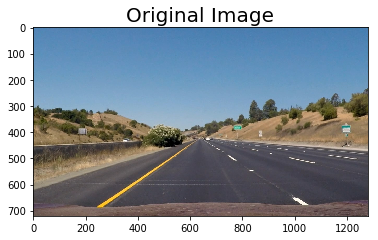

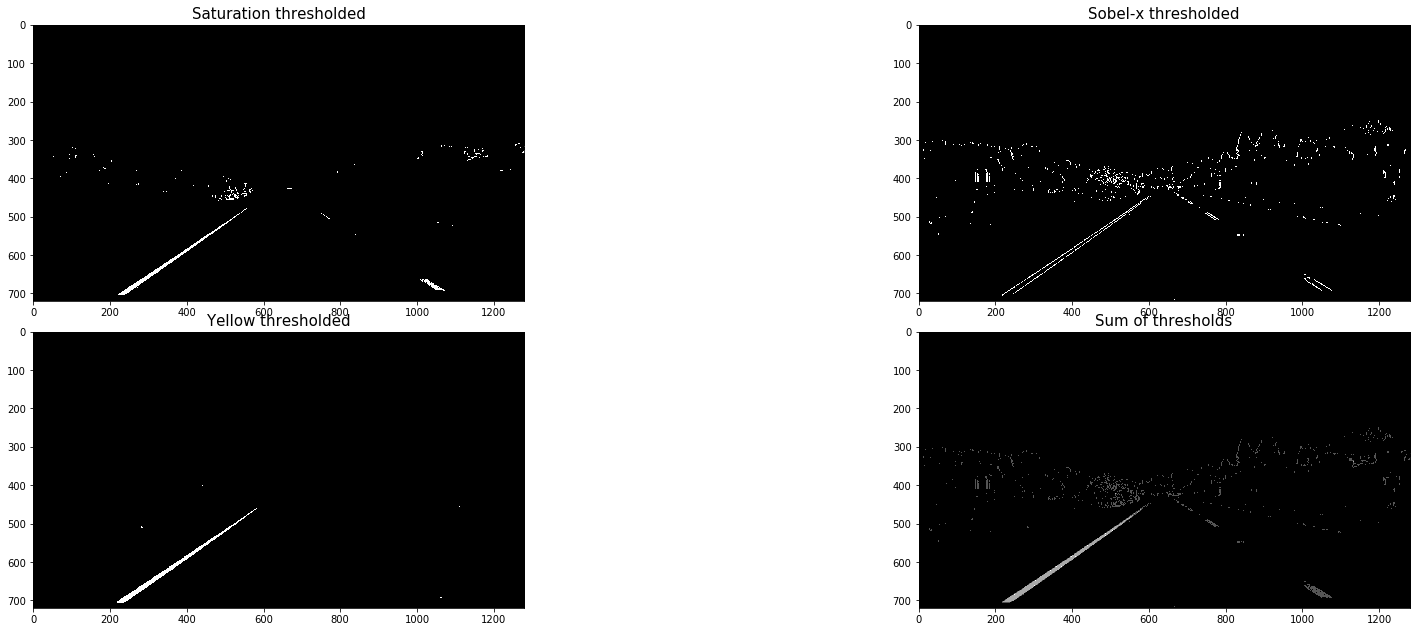

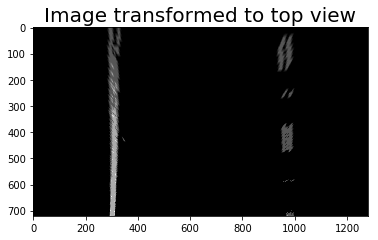

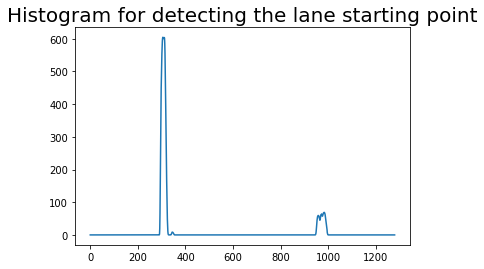

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


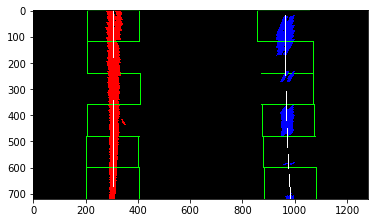

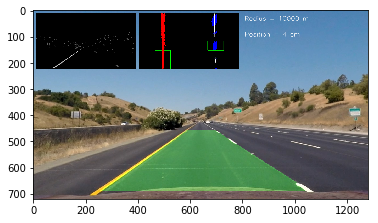

In [6]:
# Main for a single image
visualization = True

# Read image
for image_name in os.listdir("test_images/"):
    img = read_img(os.path.join("test_images/", image_name), visualization)

    ### 2) undistort image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    ### 3) Use color transforms and gradients to create a thresholded binary image.
    ### 3.1) Color transform and thresholding
    binary_saturation = detect_lines_via_saturation(undistorted, thresh=(190,255))
    ### 3.2) Gradients and thresholding
    binary_sobelx = detect_lines_via_sobel(undistorted, thresh=(50,255))
    ### 3.3) Color thresholding for yellow lines
    binary_yellow = detect_lines_via_yellow_channel(undistorted, thresh=(0.6, 0.6, 30))
    ### 3.4) Compining the 3 threshold images
    binary = combine_binaries(binary_saturation, binary_sobelx, binary_yellow, visualization)

    ### 4) Apply Perspective Transform to a top down view
    transformed = perform_perspective_transform(binary, visualization)

    ### 5) Detect lane pixels and fit to find the lane boundary.
    ### 5.1) Detect the lane starting points
    leftx_base, rightx_base = find_lane_starting(transformed, visualization)
    leftx, lefty, rightx, righty, out_img = find_lane_points(transformed, leftx_base, rightx_base)
    ploty, left_fitx, right_fitx, curve_img = fit_curve(leftx, lefty, rightx, righty, out_img, visualization)

    ### 6) Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad, car_position = measure_curvature_real(ploty, left_fitx, right_fitx) # - curve to left; + curve to right
    radius, position = (left_curverad+right_curverad)/2, car_position
    if (left_curverad > 0 and right_curverad < 0) or (left_curverad < 0 and right_curverad > 0):
        radius = 10000

    ### 7) Warp into original coordinates and highlight the lane
    result = mark_road_in_orig(undistorted, binary, curve_img, ploty, left_fitx, right_fitx, radius, position, visualization)
    break
    mpimg.imsave(os.path.join("output/", image_name), result)

In [7]:
# Main for run on video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

visualization = False

def process_image(img):

    ### 2) undistort image
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)

    ### 3) Use color transforms and gradients to create a thresholded binary image.
    ### 3.1) Color transform and thresholding
    binary_saturation = detect_lines_via_saturation(undistorted, thresh=(190,255))
    ### 3.2) Gradients and thresholding
    binary_sobelx = detect_lines_via_sobel(undistorted, thresh=(50,255))
    ### 3.3) Color thresholding for yellow lines
    binary_yellow = detect_lines_via_yellow_channel(undistorted, thresh=(0.6, 0.6, 30))
    ### 3.4) Compining the 3 threshold images
    binary = combine_binaries(binary_saturation, binary_sobelx, binary_yellow, visualization)

    ### 4) Apply Perspective Transform to a top down view
    transformed = perform_perspective_transform(binary, visualization)

    ### 5) Detect lane pixels and fit to find the lane boundary.
    ### 5.1) Detect the lane starting points
    leftx_base, rightx_base = find_lane_starting(transformed, visualization)
    leftx, lefty, rightx, righty, out_img = find_lane_points(transformed, leftx_base, rightx_base)
    ploty, left_fitx, right_fitx, curve_img = fit_curve(leftx, lefty, rightx, righty, out_img, visualization)

    ### 6) Determine the curvature of the lane and vehicle position with respect to center.
    left_curverad, right_curverad, car_position = measure_curvature_real(ploty, left_fitx, right_fitx) # - curve to left; + curve to right
    radius, position = (left_curverad+right_curverad)/2, car_position
    if (left_curverad > 0 and right_curverad < 0) or (left_curverad < 0 and right_curverad > 0):
        radius = 10000
    ### 7) Warp into original coordinates and highlight the lane
    result = mark_road_in_orig(undistorted, binary, curve_img, ploty, left_fitx, right_fitx, radius, position, visualization)
    return result



white_output = 'output/video.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)



pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html
[MoviePy] >>>> Building video output/video.mp4
[MoviePy] Writing video output/video.mp4


 99%|███████████████████████████████████████████████████████████████████████████████▎| 125/126 [00:36<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/video.mp4 

Wall time: 37.7 s
